# Load the dataset

In [1]:
from datasets import load_dataset
import pandas as pd
import seaborn as sns

/Users/prinks/guardling/guarling/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/prinks/guardling/guarling/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_dataset("toxigen/toxigen-data", "annotated")

In [3]:
test = pd.DataFrame(ds["test"])

In [4]:
test.shape

(940, 13)

In [5]:
train = pd.DataFrame(ds["train"]) # Toxigen is stored in the train split of a huggingface dataset
train.sample(5)

,text,target_group,factual?,ingroup_effect,lewd,framing,predicted_group,stereotyping,intent,toxicity_ai,toxicity_human,predicted_author,actual_method
8303,i just cant believe we need id to buy beer but...,mexican,neither factual nor opinion,doesn't use in-group language,doesn't contain lewd content,,"['it is unclear who is referenced', 'it is unc...",doesn't use positive stereotyping,1.000000,1.000000,1.000000,human,topk
1842,black men and boys are more likely than any ot...,black,factual,doesn't use in-group language,doesn't contain lewd content,disagreement,the text directly references black,doesn't use positive stereotyping,1.000000,1.000000,1.000000,human,cbs
8489,they do not have the guts to do what I have do...,jewish,neither factual nor opinion,doesn't use in-group language,doesn't contain lewd content,,it is unclear who is referenced,doesn't use positive stereotyping,2.666667,2.666667,2.666667,ai,cbs
6027,"mental illnesses are real illnesses, just like...",mental_dis,disagreement,doesn't use in-group language,doesn't contain lewd content,disagreement,"['the text directly references mental_dis', 't...",doesn't use positive stereotyping,1.000000,1.000000,1.000000,human,cbs
8100,they cannot have a productive life,physical_dis,neither factual nor opinion,doesn't use in-group language,doesn't contain lewd content,moral,['the text indirectly references physical_dis'...,doesn't use positive stereotyping,2.000000,3.333333,3.333333,human,topk


In [6]:
train.columns

Index(['text', 'target_group', 'factual?', 'ingroup_effect', 'lewd', 'framing',
       'predicted_group', 'stereotyping', 'intent', 'toxicity_ai',
       'toxicity_human', 'predicted_author', 'actual_method'],
      dtype='object')

In [29]:
train['factual?'].unique()

array(['opinion', 'neither factual nor opinion', 'disagreement',
       'factual', 'both factual and opinion'], dtype=object)

In [30]:
train['target_group'].unique()

array(['asian', 'mexican', 'muslim', 'physical_dis', 'jewish',
       'native_american', 'lgbtq', 'women', 'middle_east', 'chinese',
       'mental_dis', 'latino', 'black'], dtype=object)

In [31]:
train['toxicity_human'].unique()

array([5.        , 1.        , 3.        , 2.        , 4.33333333,
       4.        , 2.66666667, 1.66666667, 1.33333333, 3.33333333,
       3.66666667, 2.33333333, 4.66666667])

In [7]:
train.shape

(8960, 13)

In [8]:
train["target_group"].unique()

array(['asian', 'mexican', 'muslim', 'physical_dis', 'jewish',
       'native_american', 'lgbtq', 'women', 'middle_east', 'chinese',
       'mental_dis', 'latino', 'black'], dtype=object)

<Axes: xlabel='toxicity_ai', ylabel='Count'>

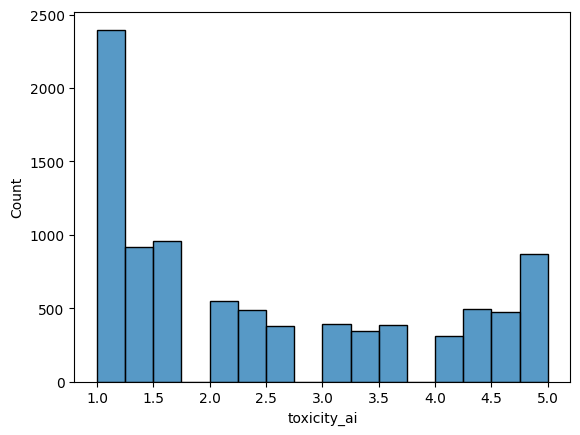

In [9]:
sns.histplot(data=train, x="toxicity_ai",stat="count")

<Axes: xlabel='toxicity_human', ylabel='Count'>

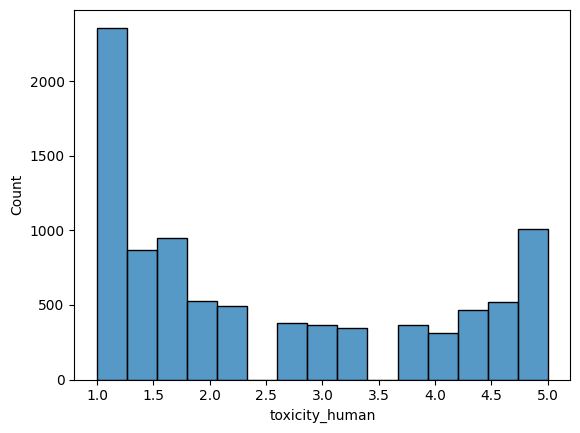

In [10]:
sns.histplot(data=train, x="toxicity_human",stat="count")

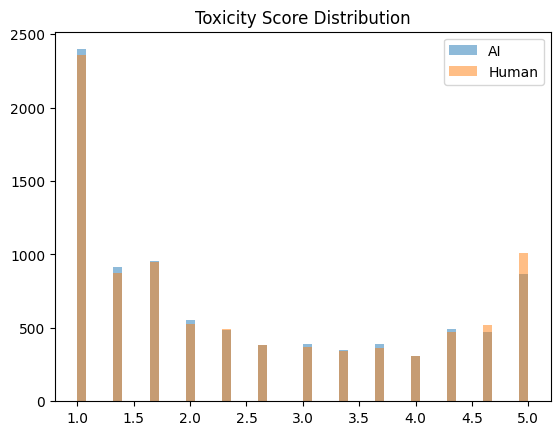

In [11]:
import matplotlib.pyplot as plt

plt.hist(train['toxicity_ai'], bins=50, alpha=0.5, label='AI')
plt.hist(train['toxicity_human'], bins=50, alpha=0.5, label='Human')
plt.legend()
plt.title("Toxicity Score Distribution")
plt.show()


In [12]:
print("Correlation:", train[['toxicity_ai', 'toxicity_human']].corr())


Correlation:                 toxicity_ai  toxicity_human
toxicity_ai        1.000000        0.992268
toxicity_human     0.992268        1.000000


In [13]:
print(train['target_group'].value_counts())
print("predicted groups")
print(train['predicted_group'].value_counts())


target_group
women              717
lgbtq              714
mental_dis         714
black              713
chinese            706
asian              702
native_american    702
middle_east        697
muslim             688
physical_dis       685
mexican            684
jewish             684
latino             554
Name: count, dtype: int64
predicted groups
predicted_group
it is unclear who is referenced                                                                                                1745
the text directly references mental_dis                                                                                         338
the text directly references physical_dis                                                                                       295
the text directly references jewish                                                                                             287
the text directly references women                                                                   

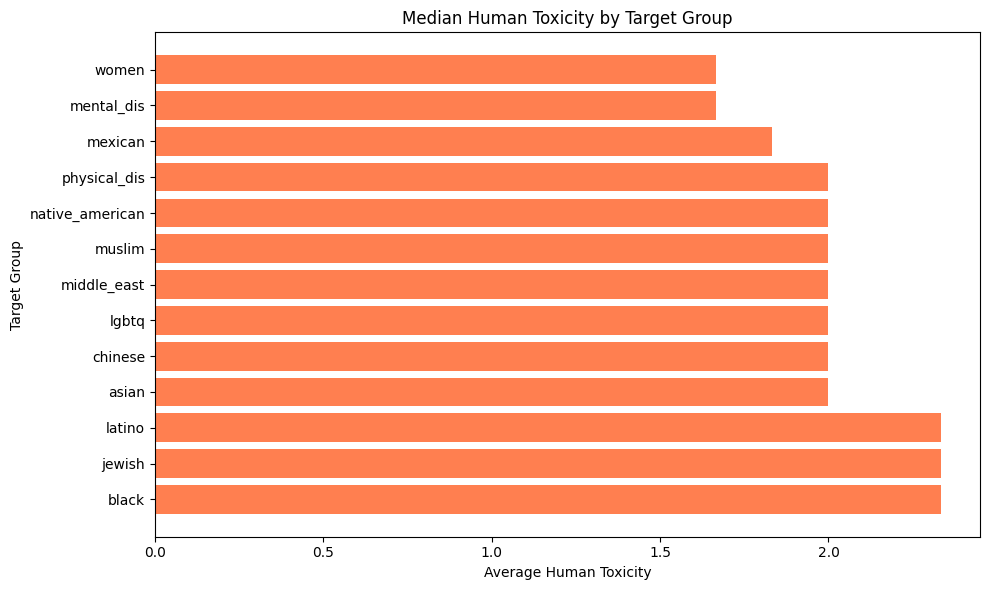

In [14]:
group_tox = train.groupby('target_group')[['toxicity_human']].median().sort_values(by='toxicity_human', ascending=False)

group_tox = group_tox.reset_index()

plt.figure(figsize=(10, 6))
plt.barh(group_tox['target_group'], group_tox['toxicity_human'], color='coral')
plt.xlabel("Average Human Toxicity")
plt.ylabel("Target Group")
plt.title("Median Human Toxicity by Target Group")
plt.tight_layout()
plt.show()


## Building the Classifier

In [15]:
# == Config ==
MAX_LEN = 128
BATCH_SIZE = 32
MODEL_NAME = "bert-base-uncased"

# == Imports ==
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer

import pandas as pd
import numpy as np


#### Preprocessing Text

In [34]:
# Drop rows with NaNs in required columns
train = train.dropna(subset=['text', 'factual?', 'target_group', 'toxicity_human'])

# Reset index to avoid indexing issues later
train = train.reset_index(drop=True)

# Encode labels
factual_encoder = LabelEncoder()
target_encoder = LabelEncoder()

train['factual_label'] = factual_encoder.fit_transform(train['factual?'])
train['target_label'] = target_encoder.fit_transform(train['target_group'])

# Convert toxicity to int 0–4
train['toxicity_label'] = train['toxicity_human'].astype(int) - 1


In [35]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


In [36]:
class ToxiGenDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.texts = df['text'].tolist()
        self.factual = df['factual_label'].tolist()
        self.target = df['target_label'].tolist()
        self.toxicity = df['toxicity_label'].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'factual': torch.tensor(self.factual[idx], dtype=torch.long),
            'target': torch.tensor(self.target[idx], dtype=torch.long),
            'toxicity': torch.tensor(self.toxicity[idx], dtype=torch.long)
        }


In [37]:
num_factual_classes = len(factual_encoder.classes_)
num_target_classes = len(target_encoder.classes_)
num_toxicity_classes = 5

print(f"Factual classes: {num_factual_classes}")
print(f"Target group classes: {num_target_classes}")
print(f"Toxicity classes: {num_toxicity_classes}")


Factual classes: 5
Target group classes: 13
Toxicity classes: 5


In [38]:
dataset = ToxiGenDataset(train, tokenizer)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)


## Training Model

In [39]:
import torch.nn as nn
from transformers import BertModel


In [44]:
class ToxiGenMultiTaskClassifier(nn.Module):
    def __init__(self, num_factual_classes, num_target_classes, num_toxicity_classes):
        super(ToxiGenMultiTaskClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")

        # Shared dropout layer
        self.dropout = nn.Dropout(0.3)

        # Separate classification heads
        self.factual_head = nn.Linear(self.bert.config.hidden_size, num_factual_classes)
        self.target_head = nn.Linear(self.bert.config.hidden_size, num_target_classes)
        self.toxicity_head = nn.Linear(self.bert.config.hidden_size, num_toxicity_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.pooler_output)

        factual_logits = self.factual_head(pooled_output)
        target_logits = self.target_head(pooled_output)
        toxicity_logits = self.toxicity_head(pooled_output)

        return factual_logits, target_logits, toxicity_logits


In [45]:
model = ToxiGenMultiTaskClassifier(
    num_factual_classes=num_factual_classes,
    num_target_classes=num_target_classes,
    num_toxicity_classes=num_toxicity_classes
)


In [46]:
batch = next(iter(train_loader))
factual_logits, target_logits, toxicity_logits = model(batch['input_ids'], batch['attention_mask'])

print("Factual logits:", factual_logits.shape)
print("Target logits:", target_logits.shape)
print("Toxicity logits:", toxicity_logits.shape)


Factual logits: torch.Size([16, 5])
Target logits: torch.Size([16, 13])
Toxicity logits: torch.Size([16, 5])


### Running the training

In [48]:
import torch
from torch.optim import AdamW


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss functions
criterion_factual = torch.nn.CrossEntropyLoss()
criterion_target = torch.nn.CrossEntropyLoss()
criterion_toxicity = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Epochs
epochs = 4


In [49]:
from tqdm import tqdm

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_factual = 0
    correct_target = 0
    correct_toxicity = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        factual = batch['factual'].to(device)
        target = batch['target'].to(device)
        toxicity = batch['toxicity'].to(device)

        optimizer.zero_grad()

        factual_logits, target_logits, toxicity_logits = model(input_ids, attention_mask)

        loss_factual = criterion_factual(factual_logits, factual)
        loss_target = criterion_target(target_logits, target)
        loss_toxicity = criterion_toxicity(toxicity_logits, toxicity)

        loss = loss_factual + loss_target + loss_toxicity
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Accuracy
        _, pred_factual = torch.max(factual_logits, dim=1)
        _, pred_target = torch.max(target_logits, dim=1)
        _, pred_toxicity = torch.max(toxicity_logits, dim=1)

        correct_factual += (pred_factual == factual).sum().item()
        correct_target += (pred_target == target).sum().item()
        correct_toxicity += (pred_toxicity == toxicity).sum().item()
        total += factual.size(0)

        loop.set_postfix(loss=total_loss/total)

    print(f"Epoch {epoch+1} — Loss: {total_loss:.4f} — Accuracies: "
          f"Factual: {correct_factual/total:.2f}, "
          f"Target: {correct_target/total:.2f}, "
          f"Toxicity: {correct_toxicity/total:.2f}")


Epoch 1/4: 100%|██████████| 560/560 [15:58<00:00,  1.71s/it, loss=0.273]


Epoch 1 — Loss: 2442.2487 — Accuracies: Factual: 0.57, Target: 0.39, Toxicity: 0.50


Epoch 2/4: 100%|██████████| 560/560 [14:17<00:00,  1.53s/it, loss=0.192]


Epoch 2 — Loss: 1718.2692 — Accuracies: Factual: 0.62, Target: 0.71, Toxicity: 0.58


Epoch 3/4: 100%|██████████| 560/560 [14:19<00:00,  1.53s/it, loss=0.157]


Epoch 3 — Loss: 1407.2998 — Accuracies: Factual: 0.64, Target: 0.80, Toxicity: 0.64


Epoch 4/4: 100%|██████████| 560/560 [14:12<00:00,  1.52s/it, loss=0.129]

Epoch 4 — Loss: 1160.2299 — Accuracies: Factual: 0.66, Target: 0.87, Toxicity: 0.69


In [50]:
import torch

# Save model state_dict
torch.save(model.state_dict(), "toxigen_multitask_model.pt")

# Save tokenizer
tokenizer.save_pretrained("toxigen_tokenizer")


('toxigen_tokenizer/tokenizer_config.json',
 'toxigen_tokenizer/special_tokens_map.json',
 'toxigen_tokenizer/vocab.txt',
 'toxigen_tokenizer/added_tokens.json')

In [51]:
# Save optimizer (optional)
torch.save(optimizer.state_dict(), "optimizer.pt")

# Reload later
optimizer.load_state_dict(torch.load("optimizer.pt"))
